In [14]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.preprocessing import scale
%matplotlib inline
%load_ext rpy2.ipython
%R library(ggplot2)

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


array(['ggplot2', 'tools', 'stats', 'graphics', 'grDevices', 'utils',
       'datasets', 'methods', 'base'], dtype='<U9')

In [3]:
path = os.path.join("data", "caseStudyCleaned.csv")
df = pd.read_csv(path)
print(df.head())
df.shape

   ID  CustomerAgeinmonths  Churn1Yes0No  CHIScoreMonth0  CHIScore01  \
0   1                 67.0           0.0             0.0         0.0   
1   2                 67.0           0.0            62.0         4.0   
2   3                 55.0           0.0             0.0         0.0   
3   4                 63.0           0.0           231.0         1.0   
4   5                 57.0           0.0            43.0         1.0   

   SupportCasesMonth0  SupportCases01  SPMonth0  SP01  Logins01  \
0                 0.0             0.0       0.0   0.0       0.0   
1                 0.0             0.0       0.0   0.0       0.0   
2                 0.0             0.0       0.0   0.0       0.0   
3                 1.0             1.0       3.0   0.0     167.0   
4                 0.0             0.0       0.0   0.0       0.0   

   BlogArticles01  Views01  DaysSinceLastLogin01  
0             0.0      0.0                  31.0  
1             0.0     16.0                  31.0  
2          

(6347, 13)

1. Is Wall’s belief about the dependence of churn rates on customer age supported by the data? To get some intuition, try visualizing this dependence (Hint: no need to run any statistical tests).

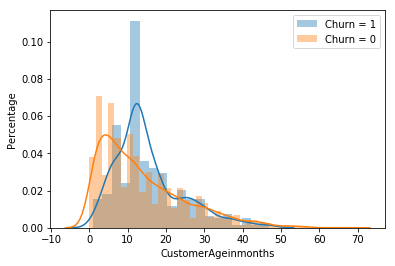

In [4]:
dp = sns.distplot((df.loc[df["Churn1Yes0No"] == 1])["CustomerAgeinmonths"], label="Churn = 1")
dp = sns.distplot((df.loc[df["Churn1Yes0No"] == 0])["CustomerAgeinmonths"], label="Churn = 0")
dp.set(xlabel='CustomerAgeinmonths', ylabel='Percentage')
dp.legend()

The dependence of churn rates on customer age is not supported from the plot. 
From the observation above, we can clearly see that the 2 histograms overlap a lot, especially at the right tail part.

2. To start, run a single regression model that best predicts the probability that a customer leaves.

In [5]:
# def findBest():
#     y = np.array([df["Churn1Yes0No"]]).T
#     col = []
#     for c in col:
#         if c == "Churn1Yes0No":
# lr = LogisticRegression(solver = 'lbfgs').fit(np.array([df["CustomerAgeinmonths"]]).T, )
# lr.coef_

In [26]:
lasso = Lasso(max_iter = 10000, normalize = True)
coefs = []
alphas = 10**np.linspace(10, -2, 100)*0.5

trainDf = df.loc[:, df.columns != "Churn1Yes0No"]
for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(trainDf, df["Churn1Yes0No"])

    for i in range(trainDf.shape[1]):
        coefs.append([a, "b_" + str(i + 1), lasso.coef_[i]])

myCoefs = pd.DataFrame(coefs, columns=['alpha', 'beta', 'beta_val'])
print(myCoefs)

             alpha  beta  beta_val
0     5.000000e+09   b_1      -0.0
1     5.000000e+09   b_2       0.0
2     5.000000e+09   b_3      -0.0
3     5.000000e+09   b_4      -0.0
4     5.000000e+09   b_5      -0.0
5     5.000000e+09   b_6      -0.0
6     5.000000e+09   b_7      -0.0
7     5.000000e+09   b_8      -0.0
8     5.000000e+09   b_9      -0.0
9     5.000000e+09  b_10      -0.0
10    5.000000e+09  b_11       0.0
11    5.000000e+09  b_12       0.0
12    3.782317e+09   b_1      -0.0
13    3.782317e+09   b_2       0.0
14    3.782317e+09   b_3      -0.0
15    3.782317e+09   b_4      -0.0
16    3.782317e+09   b_5      -0.0
17    3.782317e+09   b_6      -0.0
18    3.782317e+09   b_7      -0.0
19    3.782317e+09   b_8      -0.0
20    3.782317e+09   b_9      -0.0
21    3.782317e+09  b_10      -0.0
22    3.782317e+09  b_11       0.0
23    3.782317e+09  b_12       0.0
24    2.861184e+09   b_1      -0.0
25    2.861184e+09   b_2       0.0
26    2.861184e+09   b_3      -0.0
27    2.861184e+09  

In [11]:
%R -i myCoefs

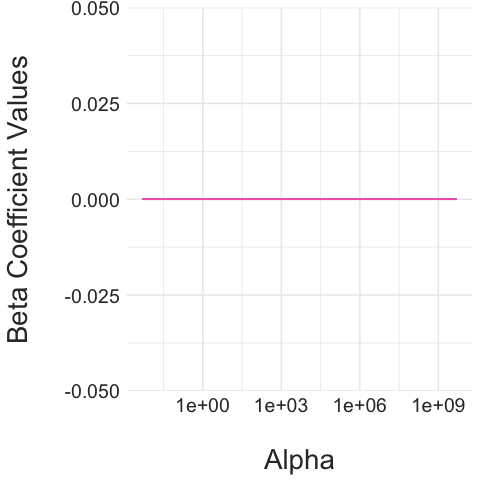

In [25]:
%%R -r 100

ggplot() +
    geom_line(aes(x = alpha, y = beta_val, color = beta), data = myCoefs) + 
    theme_minimal() +
    scale_x_continuous(trans='log10') + 
    theme(axis.text = element_text(color = "grey20", size = 14),
            axis.title = element_text(color = "grey20", size = 20)) + 
    xlab('\nAlpha') + 
    ylab('Beta Coefficient Values\n') +
    guides(colour = F)

    a. What is the predicted probability that Customer 672 will leave between December 2011 and February 2012? Is that high or low? Did that customer actually leave?

In [9]:
cus = df.iloc[671:672][:]
print(cus)

      ID  CustomerAgeinmonths  Churn1Yes0No  CHIScoreMonth0  CHIScore01  \
671  672                 16.0           0.0           148.0         1.0   

     SupportCasesMonth0  SupportCases01  SPMonth0  SP01  Logins01  \
671                 0.0             0.0       0.0   0.0      17.0   

     BlogArticles01  Views01  DaysSinceLastLogin01  
671             1.0     85.0                   2.0  


    b. What about Customers 354 and 5,203?

In [10]:
cus = df.iloc[353:354][:]
print(cus)
cus = df.iloc[5202:5203][:]
print(cus)

      ID  CustomerAgeinmonths  Churn1Yes0No  CHIScoreMonth0  CHIScore01  \
353  354                 13.0           0.0           139.0        29.0   

     SupportCasesMonth0  SupportCases01  SPMonth0  SP01  Logins01  \
353                 0.0             0.0       0.0   0.0       4.0   

     BlogArticles01  Views01  DaysSinceLastLogin01  
353             1.0    244.0                   1.0  
        ID  CustomerAgeinmonths  Churn1Yes0No  CHIScoreMonth0  CHIScore01  \
5202  5203                  4.0           0.0            37.0        32.0   

      SupportCasesMonth0  SupportCases01  SPMonth0  SP01  Logins01  \
5202                 1.0             1.0       0.0   0.0       0.0   

      BlogArticles01  Views01  DaysSinceLastLogin01  
5202             0.0      1.0                   5.0  


3. How sensible is the approach with a single model? Can you suggest a better approach?

    a. Provide updated estimates of probabilities that Customers 672, 354, and 5,203 will leave.

    b. What factors contribute the most to the predicted probabilities that these customers will leave?

4. Answer Wall’s “ultimate question”: provide the list of 100 customers with highest churn
probabilities and the top three drivers of churn for each customer.